# Validation of method

### Table of contents

1. [**Heteroscedastic GP**](#hetero)
3. [**Renewal process GP**](#renewal)
4. [**GP-GLM**](#gpglm)

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
import numpy as np
import scipy
from scipy.ndimage import convolve1d

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

from tqdm.autonotebook import tqdm

import sys
sys.path.append("..")
import gaussneuro as gn


import matplotlib.pyplot as plt

/tmp/ipykernel_21822/3067458024.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = True

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [71]:
B, L, a, c = 100, 100., 10.0, 1.
filter_length = 500
obs_dims = B

ini_var = 1.0
a = a * np.ones((obs_dims, 1))
c = c * np.ones((obs_dims, 1))
phi_h = np.linspace(0.0, L, B)[:, None, None].repeat(obs_dims, axis=1)
w_h = np.zeros_like((np.sqrt(ini_var) * rng.normal(size=(B, obs_dims)))[..., None])
for o in range(obs_dims):
    w_h[o, o, :] = 1.

flt = gn.filters.FIR.RaisedCosineBumps(
    a,
    c,
    w_h,
    phi_h,
    filter_length,
)

In [72]:
filter_t, KL = flt.compute_filter(prng_state, True, None)

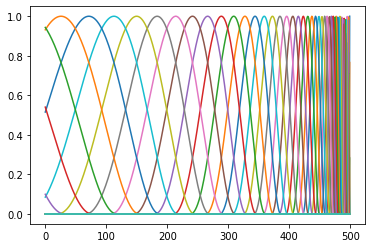

In [73]:
fig = plt.figure()
ax = fig.subplots()

t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])
plt.show()

In [95]:
filter_length = 500
obs_dims = 9

num_induc = 10
x_dims = 1

# qSVGP inducing points
induc_locs = np.linspace(0, 500, num_induc)[None, :, None].repeat(obs_dims, axis=0)
u_mu = 1.0*rng.normal(size=(obs_dims, num_induc, 1))
u_Lcov = 0.1*np.eye(num_induc)[None, ...].repeat(obs_dims, axis=0)

# kernel
len_fx = 100.0*np.ones((obs_dims, x_dims))  # GP lengthscale
var_f = 1.0*np.ones(obs_dims)  # kernel variance

#kern = gn.GP.kernels.SquaredExponential(
#    obs_dims, variance=var_f, lengthscale=len_fx, array_type=array_type)
kern = gn.GP.kernels.DecayingSquaredExponential(
    obs_dims, variance=var_f, lengthscale=len_fx, 
    beta=var_f, lengthscale_beta=1.5*len_fx, array_type=array_type)
gp = gn.GP.sparse.qSVGP(kern, induc_locs, u_mu, u_Lcov, RFF_num_feats=0, whitened=False)

a_r = -10.*np.ones(obs_dims)
tau_r = 10.*np.ones(obs_dims)

flt = gn.filters.FIR.GaussianProcess(
    gp, 
    a_r,
    tau_r, 
    filter_length,
    False, 
)

In [96]:
filter_t, KL = flt.compute_filter(prng_state, True, None, jitter=1e-10)

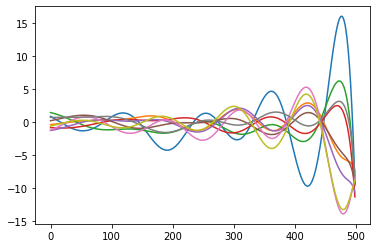

In [97]:
fig = plt.figure()
ax = fig.subplots()

t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])
plt.show()

### Synthetic GLM data

In [4]:
T = 5000
runs = 1

T_int = 1000
I_ext = np.zeros((runs, T))

sample_bin = 0.001
        
for r in range(runs):    
    I_ext[r, T_int:-T_int] = r/10. + 10.

In [5]:
w_h = np.array([-0.1, -1.0])[:, None, None]*np.ones((2, 1, 1))
phi_h = np.array([[[3.0]], [[1.0]]])

hist_len = 100 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len)
a_t = hist_couple.compute_filter()

In [18]:
w_s = np.array([0.1, 1.0, -0.4])[:, None, None]*np.ones((3, 1, 1))
phi_s = np.array([[[4.0]], [[1.0]], [[3.0]]])
stim_hist = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_s, w=w_s, timesteps=hist_len)
VI_tuples = [(None, None, None, 1)]

covariates = [I_ext[0, :]]
input_group = mdl.inference.input_group(1, VI_tuples, stimulus_filter=stim_hist)
input_group.set_XZ(covariates, T, batch_size=5000, filter_len=hist_len)



# GLM validation with synthetic GLM data
#ivlink = 'exp'
ivlink = lambda x: torch.sigmoid(x)/sample_bin

glm_rate = mdl.parametrics.GLM(1, 1, 1, ivlink, bias=True)
glm_rate.set_params(np.array([[1.0]]), np.array([[-20.0]]))

#w_h = np.array([2.1, -2.0, -2.0])[:, None, None]*np.ones((3, 1, 1))
#phi_h = np.array([[[4.0]], [[3.0]], [[1.0]]])
w_h = np.array([-0.1, -1.0])[:, None, None]*np.ones((2, 1, 1))
phi_h = np.array([[[3.0]], [[1.0]]])

hist_len = 99 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len-1)
#likelihood = mdl.likelihoods.Poisson(1, ivlink)
_likelihood = mdl.likelihoods.Bernoulli(sample_bin, 1, ivlink)

likelihood = mdl.filters.filtered_likelihood(_likelihood, hist_couple)


glm = mdl.inference.VI_optimized(input_group, glm_rate, likelihood)
glm.to(dev)

VI_optimized(
  (inputs): input_group(
    (stimulus_filter): raised_cosine_bumps()
  )
  (mapping): GLM()
  (likelihood): filtered_likelihood(
    (likelihood): Bernoulli()
    (filter): raised_cosine_bumps()
  )
)

In [1]:
_, rate, _ = glm.evaluate(0)
syn_train = glm.likelihood.sample(rate[0].cpu().numpy())

NameError: name 'glm' is not defined

In [81]:
# sample
neurons = glm.neurons
hist_len = glm.filter_len-1

trials = 1
ini_train = np.zeros((trials, neurons, hist_len))

syn_train, _, _ = glm.sample([I_ext.flatten()], ini_train)
syn_t_spike = []
for n in range(neurons):
    syn_t_spike.append(neural_utils.BinToTrain(syn_train[0, n]))
    
syn_train = syn_train[0]

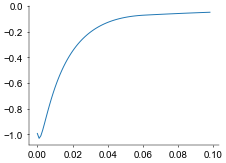

In [82]:
fig = plt.figure()
ax = fig.subplots()
a_t = hist_couple.compute_filter()

t = np.arange(a_t.shape[-1])*sample_bin
ax.plot(t, a_t.data.cpu().numpy()[0, 0, ::-1])

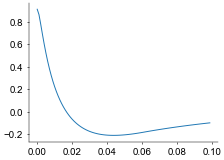

In [83]:
# stimulus history filter
a = stim_hist.compute_filter()
a = a.data[0,0].cpu().numpy()
t = np.arange(len(a))*sample_bin
plt.plot(t, a[::-1])
plt.show()

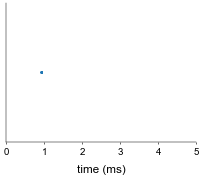

In [88]:
plt.scatter(syn_t_spike[0]*sample_bin, np.ones_like(syn_t_spike[0]), marker='|')
plt.xlim(0, 5)
plt.yticks([])
plt.xlabel('time (ms)')
plt.show()

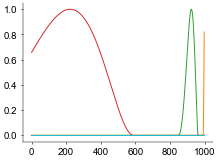

In [161]:
fig = plt.figure()
ax = fig.subplots()
neurons = 1
B = 10
hist_len = 19

for k in range(B):
    w_h = 0.0*np.random.randn(B, neurons, 1)
    w_h[k, :, :] = 1
    phi_h = np.linspace(0, 6.0, B)[:, None, None].repeat(neurons, axis=1)

    hist_couple = mdl.filters.raised_cosine_bumps(a=3., c=0.0, phi=phi_h, w=w_h, timesteps=hist_len, 
                                                conv_groups=neurons, learnable=[False, False, False, True])

    a_t = hist_couple.compute_filter()

    t = np.arange(a_t.shape[-1])*sample_bin
    ax.plot(t, a_t.data.cpu().numpy()[0, 0, ::-1])

plt.show()



### Single neuron GLM

In [92]:
def set_glm(I_ext, syn_train, batch_size, neurons, sample_bin, mode, stimhist=False, bernoulli=False, noisy=True):
    
    if mode == 'gph':
        num_induc = 8
        l = 100*sample_bin*np.ones((1, neurons))
        l_b = 1000*sample_bin*np.ones((1, neurons))
        beta = np.zeros((1, neurons))
        l_l = 10.*np.array([np.ones(neurons)])
        v = np.ones(neurons)

        kernel_tuples = [('variance', v), 
                         ('DSE', 'euclid', l, l_b, beta), 
                         ('RBF', 'euclid', l_l)]
        inducing_points = np.linspace(-1, 1, num_induc)[None, :, None].repeat(neurons, axis=0)

        mean_func = mdl.filters.decaying_exponential(neurons, -1., 1000*sample_bin)
    
        hist_len = 999
        hist_couple = mdl.filters.hetero_GP_filter(1, neurons, hist_len, sample_bin, [(None,)], 
                                                   [(None,)], inducing_points, kernel_tuples, mean_func, 
                                                   conv_groups=neurons, tens_type=torch.float, 
                                                   inner_loop_bs=10, shared_kernel_params=False, noisy=noisy)
    elif mode == 'gp':
        l = 100*sample_bin*np.ones((1, neurons))
        l_b = 1000*sample_bin*np.ones((1, neurons))
        beta = np.zeros((1, neurons))
        v = np.ones(neurons)

        kernel_tuples = [('variance', v), 
                          ('DSE', 'euclid', l, l_b, beta)]

        mean_func = mdl.filters.decaying_exponential(neurons, -1., 1000*sample_bin)
    
        hist_len = 999
        hist_couple = mdl.filters.GP_filter(1, neurons, hist_len, sample_bin, kernel_tuples, mean_func, 
                                            num_induc=6, conv_groups=neurons, tens_type=torch.float, 
                                            noisy=noisy)
    elif mode == 'rcb':
        w_h = 0.01*np.random.randn(8, neurons, 1)
        phi_h = np.linspace(0, 1, 8)[:, None, None]*5.+0.5

        hist_len = 999
        hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len, 
                                                      learnable=[False, False, False, True])
    else:
        raise ValueError

    if stimhist:
        w_s = 0.01*np.random.randn(6, neurons, 1)
        w_s[0, :, :] = 1.
        phi_s = np.linspace(0, 1, 6)[:, None, None]*5.+0.5
        stim_hist = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_s, w=w_s, timesteps=hist_len+1,
                                                    learnable=[False, False, False, True])
    else:
        stim_hist = None
        
    if bernoulli:
        ivlink = lambda x: torch.sigmoid(x)/sample_bin
    else:
        ivlink = 'exp'

    ini_X = [I_ext.flatten()]
    T = I_ext.flatten().shape[0]
    #prior_tuples = [(None,)]
    #var_tuples = [(None,)]
    prior_tuples = [('Normal', 'euclid', 0.0, 1.0, False, False)]
    var_tuples = [('Normal', 'euclid')]
    
    glm_rate = mdl.parametrics.GLM(neurons, 1, 1, ivlink, prior_tuples, var_tuples, bias=True)
    glm_rate.set_params(sample_bin, w=np.zeros((neurons, 1)))
    
    if bernoulli:
        likelihood = mdl.likelihoods.Bernoulli(neurons, ivlink)
    else:
        likelihood = mdl.likelihoods.Poisson(neurons, ivlink)
    likelihood.set_params(sample_bin)
    
    glm = mdl.inference.nll_optimized([glm_rate], likelihood, stim_hist=stim_hist, spk_couple=hist_couple)
    glm.preprocess(ini_X, T, syn_train, batch_size=batch_size)
    return glm


Stopped at epoch 504.


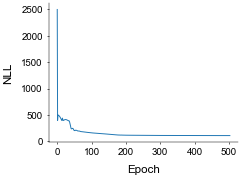


Stopped at epoch 273.



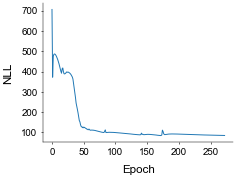

In [93]:
modes = ['rcb', 'gp']
syn_train = spiketrain.reshape(1, -1)

for mode in modes:
    glm = set_glm(I_ext, syn_train, syn_train[0].shape[0], 1, sample_bin, mode, stimhist=True, bernoulli=True,
                  noisy=True)
    glm.to(dev)

    # fit
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 1e-1,
                   'rate_model.0.w': 1e-1}
    glm.set_optimizers(opt_tuple, opt_lr_dict)

    losses = glm.fit(10000, loss_margin=-1e-2, stop_iters=100, cov_samples=1, ll_samples=10)

    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()
    
    # save model
    model_name = 'GLM_{}_{}'.format(mode, dynamics)
    torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)

In [113]:
hist_len = 999
filter_data = []
sample_data = []
cond_data = []

for mode in modes:
    glm = set_glm(I_ext, syn_train, syn_train[0].shape[0], 1, sample_bin, mode, stimhist=True, bernoulli=True, noisy=True)
    glm.to(dev)

    model_name = 'GLM_{}_{}'.format(mode, dynamics)
    checkpoint = torch.load('./checkpoint/' + model_name)
    glm.load_state_dict(checkpoint['glm'])
    
    if glm.stim_hist is not None:
        stim_filt = glm.stim_hist.compute_filter()
        stim_filt = stim_filt.data[0,0].cpu().numpy()[::-1]
    else:
        stim_filt = None
    
    if mode == 'rcb':
        spike_filter = glm.spk_couple.compute_filter()
        spike_filter = spike_filter.data[0,0].cpu().numpy()[::-1]
        filter_data.append((spike_filter, stim_filt))
    elif mode == 'gp':
        glm.noisy = False
        spike_filter, a_v = glm.spk_couple.compute_filter()
        spike_filter = spike_filter[0, 0].data.cpu().numpy()[::-1]
        spike_filter_s = a_v[0, 0].data.sqrt().cpu().numpy()[::-1]
        filter_data.append((spike_filter, spike_filter_s, stim_filt))
        
    spk = glm.likelihood.spikes[0][None].to(glm.rate_model[0].tbin.device)
    spk = torch.cat((torch.zeros((1, 1, hist_len-1), device=spk.device), spk), dim=-1)
    sphist = glm.spk_couple(spk).data.cpu().numpy()[0,0]
    cov_, _ = glm.rate_model[0].sample_covariates(0, 1, None) # samples, timesteps, dims
    cov_ = torch.cat((torch.zeros((1, hist_len, 1), device=spk.device), cov_), dim=1)
    sthist = glm.stim_hist(cov_.permute(0, 2, 1)).permute(0, 2, 1).data.cpu().numpy()[0, :, 0]
    cond_data.append((sphist, sthist))
        
    # sample from the model
    glm_trials = 5
    ini_train = np.zeros((glm_trials, 1, hist_len))
    tr, _, _ = glm.sample([np.concatenate((np.zeros(hist_len), I_ext[0]))], ini_train)
    sample_data.append(tr)

In [ ]:
print(glm.rate_model[0].w)
print(glm.rate_model[0].bias)
print(glm.spk_couple.a)
print(glm.spk_couple.c)

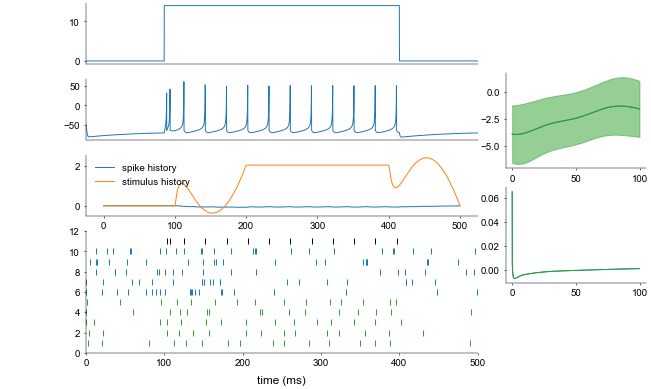

In [114]:
fig = plt.figure(figsize=(8,5)) # plot fits
fig.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)

time_bins = I_ext[0].shape[0]
tt = np.arange(time_bins)*dt



widths = [1]
heights = [1, 1, 1, 2]
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.7, bottom=0., top=1.0)


# visualize the input current
ax = fig.add_subplot(spec[0, 0])
ax.plot(tt, I_ext[0])
ax.set_xlim(0, time_bins * dt)
ax.set_xticks([])

# Biophysical
ax = fig.add_subplot(spec[1, 0])
ax.plot(tt, state[0, :, 0])
ax.set_xlim(0, time_bins * dt)
ax.set_xticks([])

# visualize GLM conditional intensity on data
sphist, sthist = cond_data[0]
ax = fig.add_subplot(spec[2, 0])
ax.plot(tt, sphist, label='spike history')
ax.plot(tt, sthist, label='stimulus history')
ax.legend()



ax = fig.add_subplot(spec[3, 0])

# Data
t = np.nonzero(spiketrain[0])[0]*dt
ax.scatter(t, (2*glm_trials+1) * np.ones_like(t), c='k', s=40, marker='|')

# GLM repeats
tr = sample_data[0]
for i in range(glm_trials):
    t = np.nonzero(tr[i, 0])[0]*dt
    ax.scatter(t, (i+1+glm_trials) * np.ones_like(t), c='tab:blue', s=40, marker='|')

tr = sample_data[1]
for i in range(glm_trials):
    t = np.nonzero(tr[i, 0])[0]*dt
    ax.scatter(t, (i+1) * np.ones_like(t), c='tab:green', s=40, marker='|')
    

ax.set_xlim(0, time_bins * dt)
ax.set_ylim(0, 2*glm_trials+2)
#ax.set_yticks(np.arange(1, units+1))
ax.set_xlabel('time (ms)')



widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights, 
                        left=0.75, right=1.0, bottom=0.2, top=0.8)


axhist = fig.add_subplot(spec[0, 0])
axstim = fig.add_subplot(spec[1, 0])


spikefilter, stimfilter = filter_data[0]
t = np.arange(len(spike_filter))*sample_bin
axhist.plot(t, spike_filter, color='tab:blue')
t = np.arange(len(stim_filt))*sample_bin
axstim.plot(t, stim_filt, color='tab:blue')


spike_filter, spike_filter_s, stim_filt = filter_data[1]
t = np.arange(len(spike_filter))*sample_bin
line, = axhist.plot(t, spike_filter, color='tab:green')
axhist.fill_between(
    t, (spike_filter-spike_filter_s),
    (spike_filter+spike_filter_s), color=line.get_color(), alpha=0.5
)
t = np.arange(len(stim_filt))*sample_bin
axstim.plot(t, stim_filt, color='tab:green')





plt.show()

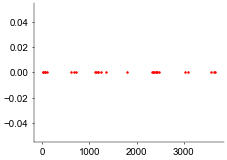

In [27]:
# plot spike raster
s = tr[0, 0].nonzero()[0][:]
plt.scatter(s, np.zeros_like(s), marker='.', color='r')
plt.show()